In [1]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.0.dev2151-g2a716
Compiled: Dec 23 2014 21:10:53



In [2]:
dwiScan='/Shared/johnsonhj/TrackOn/Experiments/20140203_DWIProcessing/VISUALLY_INSPECTED/HDNI_003/823955340/823955340_20080609_30/823955340_823955340_20080609_30_DWI_CONCAT_QCed_INSPECTED.nrrd'
DWI = sitk.ReadImage(dwiScan)

In [3]:
import os
import glob
import sys

#\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
#####################################################################################
#     Prepend the shell environment search paths
PROGRAM_PATHS = '/scratch/BS/release/bin'
PROGRAM_PATHS = PROGRAM_PATHS.split(':')
PROGRAM_PATHS.extend(os.environ['PATH'].split(':'))
os.environ['PATH'] = ':'.join(PROGRAM_PATHS)

CUSTOM_ENVIRONMENT=dict()

# Platform specific information
#     Prepend the python search paths
PYTHON_AUX_PATHS = '/scratch/BS/BRAINSTools/AutoWorkup'
PYTHON_AUX_PATHS = PYTHON_AUX_PATHS.split(':')
PYTHON_AUX_PATHS.extend(sys.path)
sys.path = PYTHON_AUX_PATHS

import SimpleITK as sitk
import nipype
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, File, Directory
from nipype.interfaces.base import traits, isdefined, BaseInterface
from nipype.interfaces.utility import Merge, Split, Function, Rename, IdentityInterface
import nipype.interfaces.io as nio   # Data i/oS
import nipype.pipeline.engine as pe  # pypeline engine
from nipype.interfaces.freesurfer import ReconAll
from SEMTools import *

In [4]:
myExtracter = extractNrrdVectorIndex()
myExtracter.inputs.inputVolume = dwiScan
myExtracter.inputs.vectorIndex = 0
myExtracter.inputs.outputVolume = 'B0_Image.nrrd'
print(myExtracter.cmdline)
myExtracter.run()

INFO:interface:stdout 2015-01-05T18:13:58.778469:Input Image: /Shared/johnsonhj/TrackOn/Experiments/20140203_DWIProcessing/VISUALLY_INSPECTED/HDNI_003/823955340/823955340_20080609_30/823955340_823955340_20080609_30_DWI_CONCAT_QCed_INSPECTED.nrrd
INFO:interface:stdout 2015-01-05T18:13:58.778469:Output Image: B0_Image.nrrd
INFO:interface:stdout 2015-01-05T18:13:58.778469:Vector Index: 0
INFO:interface:stdout 2015-01-05T18:13:58.778469:Set Image Orientation: AsAcquired
INFO:interface:stdout 2015-01-05T18:13:58.778469:


 extractNrrdVectorIndex  --inputVolume /Shared/johnsonhj/TrackOn/Experiments/20140203_DWIProcessing/VISUALLY_INSPECTED/HDNI_003/823955340/823955340_20080609_30/823955340_823955340_20080609_30_DWI_CONCAT_QCed_INSPECTED.nrrd --outputVolume B0_Image.nrrd --vectorIndex 0


(0.9995715721169656, -0.02438591252610002, -0.01618639817521977, 0.02423670429996012, 0.9996625118343209, -0.009351181624441226, 0.016408972554500093, 0.008954870371240008, 0.9998252626916065)
(112, 112, 64)
(-109.00943095799, -109.76748792094, -56.692274943286)


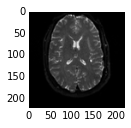

In [12]:
b0Image=sitk.ReadImage(myExtracter.inputs.outputVolume)
print(b0Image.GetDirection())
myshow(b0Image)
print(b0Image.GetSize())
print(b0Image.GetOrigin())

In [16]:
b0Image2=sitk.Image(b0Image)
b0Image2.SetDirection([1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0])
print(b0Image2.GetDirection())
print(b0Image2.GetSize())
print(b0Image2.GetOrigin())

(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(112, 112, 64)
(-109.00943095799, -109.76748792094, -56.692274943286)


In [28]:
tsyn=sitk.ReadTransform('/scratch/TESTS/IpythonNotebook/1_DWI_Nipype_workflow/DWIWorkflow_823955340_20080609_30/antsReg_B0ToTransformedT2/TsynComposite.h5')
trigInv=sitk.ReadTransform('/scratch/TESTS/IpythonNotebook/1_DWI_Nipype_workflow/DWIWorkflow_823955340_20080609_30/GetRigidTransformInverse/Inverse_T2ToB0_RigidTransform.h5')

trigInv.AddTransform(tsyn)
#print(tsyn)
newOrig=trigInv.TransformPoint(b0Image2.GetOrigin())
print(newOrig)

(-110.10844187676763, -146.69965369998457, -46.12878453293507)


(182, 224, 196)


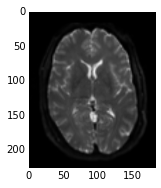

In [29]:
correctedB0=sitk.ReadImage('/scratch/TESTS/IpythonNotebook/1_DWI_Nipype_workflow/DWIWorkflow_823955340_20080609_30/gtractResampleDWIInPlace_Trigid/CorrectedDW_in_T2Space_B0.nrrd')
myshow(correctedB0)
print(correctedB0.GetSize())

In [30]:
rs=sitk.ResampleImageFilter()
rs.SetOutputSpacing(b0Image.GetSpacing())
rs.SetOutputOrigin(newOrig)
rs.SetSize(b0Image.GetSize())
CorrectedB0Resampled = rs.Execute(correctedB0)

(112, 112, 64)


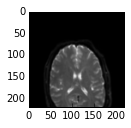

In [31]:
myshow(CorrectedB0Resampled)
print(CorrectedB0Resampled.GetSize())

In [32]:
sitk.WriteImage(CorrectedB0Resampled,'/scratch/TESTS/IpythonNotebook/1_DWI_Nipype_workflow/CorrectedB0Resampled.nrrd')